In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import norm
import scipy.integrate as integrate
import timeit
from operator import mul
from functools import reduce

In [102]:
np.random.seed(2)

In [103]:
## Set parameters

# data parameters
size = 30
mean_mu = 0
sigma_mu = 2
sigma_x = 1

# model parameters
prior_mean_mu = 0
prior_sigma_mu = 2
prior_sigma_x = 1

# plot parameters
resolution_joint_mu = 200
resolution_joint_x = 200
range_joint_mu_upper = 4
range_joint_mu_lower = -4
range_joint_x_upper = 4
range_joint_x_lower = -4
resolution_marginal_mu = 101
resolution_marginal_x = 101
range_marginal_mu_upper = 4
range_marginal_mu_lower = -4
range_marginal_x_upper = 4
range_marginal_x_lower = -4

In [104]:
## Generate data
mu = np.random.normal(mean_mu,sigma_mu,size=size)
X = np.random.normal(mu,sigma_x,size=size)

In [105]:
## Calculate joint posterior distribution
def prior_mu(mu):
    density = norm.pdf(mu, loc=prior_mean_mu, scale=prior_sigma_mu)
    return density

def likelihood_x(x,mu):
    density = norm.pdf(x, loc=mu, scale=prior_sigma_x)
    return density

def likelihood_X(X,mu): 
    likelihoods = [likelihood_x(point,mu) for point in X]
    res = reduce(mul, likelihoods, 1)
    return res

#def likelihood_times_prior_mu(X,mu):
#    return likelihood_X(X,mu) * prior_mu(mu)

#def prior_X(X):
#    res = integrate.quad(lambda mu: likelihood_times_prior_mu(X,mu),a=-np.inf,b=np.inf)[0]
#    return res

#def joint_posterior(x,mu,X):
#    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu) / prior_X(X)
#    return res

def joint_posterior_without_normalizing_constant(x,mu,X):
    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu)
    return res

def posterior_marginal_x_without_normalizing_constant(x,X):
    res = integrate.quad(lambda mu:joint_posterior_without_normalizing_constant(mu=mu,X=X,x=x),a=-np.inf,b=np.inf)[0]
    return res

#def posterior_marginal_mu(mu,X):
#    res = likelihood_X(X,mu) * prior_mu(mu) / prior_X(X)
#return res

def posterior_marginal_mu_without_normalizing_constant(mu,X):
    res = likelihood_X(X,mu) * prior_mu(mu) 
    return res

In [106]:
## Improve performance of calculations

def prior_mu_vectorized(mu_vector):
    res = [prior_mu(mu) for mu in mu_vector]
    return res

def likelihood_X_vectorized(X,mu_vector):
    res = [likelihood_X(X,mu) for mu in mu_vector]
    return res

def likelihood_x_vectorized(x_vector,mu_vector):
    res = [likelihood_x(x,mu) for x in x_vector for mu in mu_vector]
    res = np.reshape(np.asarray(res),(resolution_joint_x,resolution_joint_mu))
    return res

def joint_posterior_without_normalizing_constant_vectorized(x_vector,mu_vector,X):
    res = np.multiply(prior_mu_vectorized(mu_vector),likelihood_X_vectorized(X,mu_vector))
    res = np.multiply(likelihood_x_vectorized(x_vector,mu_vector),res)
    return res

In [107]:
## Build grid for plotting joint posterior distribution

mu_plot = linspace(range_joint_mu_lower,range_joint_mu_upper,resolution_joint_mu)
x_plot = linspace(range_joint_x_lower,range_joint_x_upper,resolution_joint_x)

grid = joint_posterior_without_normalizing_constant_vectorized(x_plot,mu_plot,X)

In [108]:
## Calculate marginals for visualization
range_marginals_mu = np.linspace(range_marginal_mu_lower,range_marginal_mu_upper,resolution_marginal_mu)
range_marginals_x  = np.linspace(range_marginal_x_lower, range_marginal_x_upper, resolution_marginal_x)

marginals_mu = [posterior_marginal_mu_without_normalizing_constant(mu,X) for mu in range_marginals_mu]
marginals_x = [posterior_marginal_x_without_normalizing_constant(x,X) for x in range_marginals_x]

In [159]:
## Calculate aggregations

# Maximum
mu_max = max(marginals_mu)
mu_max_index = marginals_mu.index(mu_max)
mu_max_plot_position = range_marginals_mu[mu_max_index]

x_max = max(marginals_x)
x_max_index = marginals_x.index(x_max)
x_max_plot_position = range_marginals_x[x_max_index]

# Variance
marginals_mu_normalized = marginals_mu / sum(marginals_mu)
marginals_mu_normalized_increased_rounded = np.round(marginals_mu_normalized * resolution_marginal_mu).astype(int)
 # Generate each value of range_marginals as much as the normalized increased rounded density for this value is
simulated_mu = [range_marginals_mu[i] for i in range(0,resolution_marginal_mu) for j in range(0,marginals_mu_normalized_increased_rounded[i])]
simulated_mu_sd = np.sqrt(np.var(simulated_mu))

marginals_x_normalized = marginals_x / sum(marginals_x)
marginals_x_normalized_increased_rounded = np.round(marginals_x_normalized * resolution_marginal_x).astype(int)
 # Generate each value of range_marginals as much as the normalized increased rounded density for this value is
simulated_x = [range_marginals_x[i] for i in range(0,resolution_marginal_x) for j in range(0,marginals_x_normalized_increased_rounded[i])]
simulated_x_sd = np.sqrt(np.var(simulated_x))

Text(0.5, 1.0, 'Joint Posterior Distribution (not normalized)')

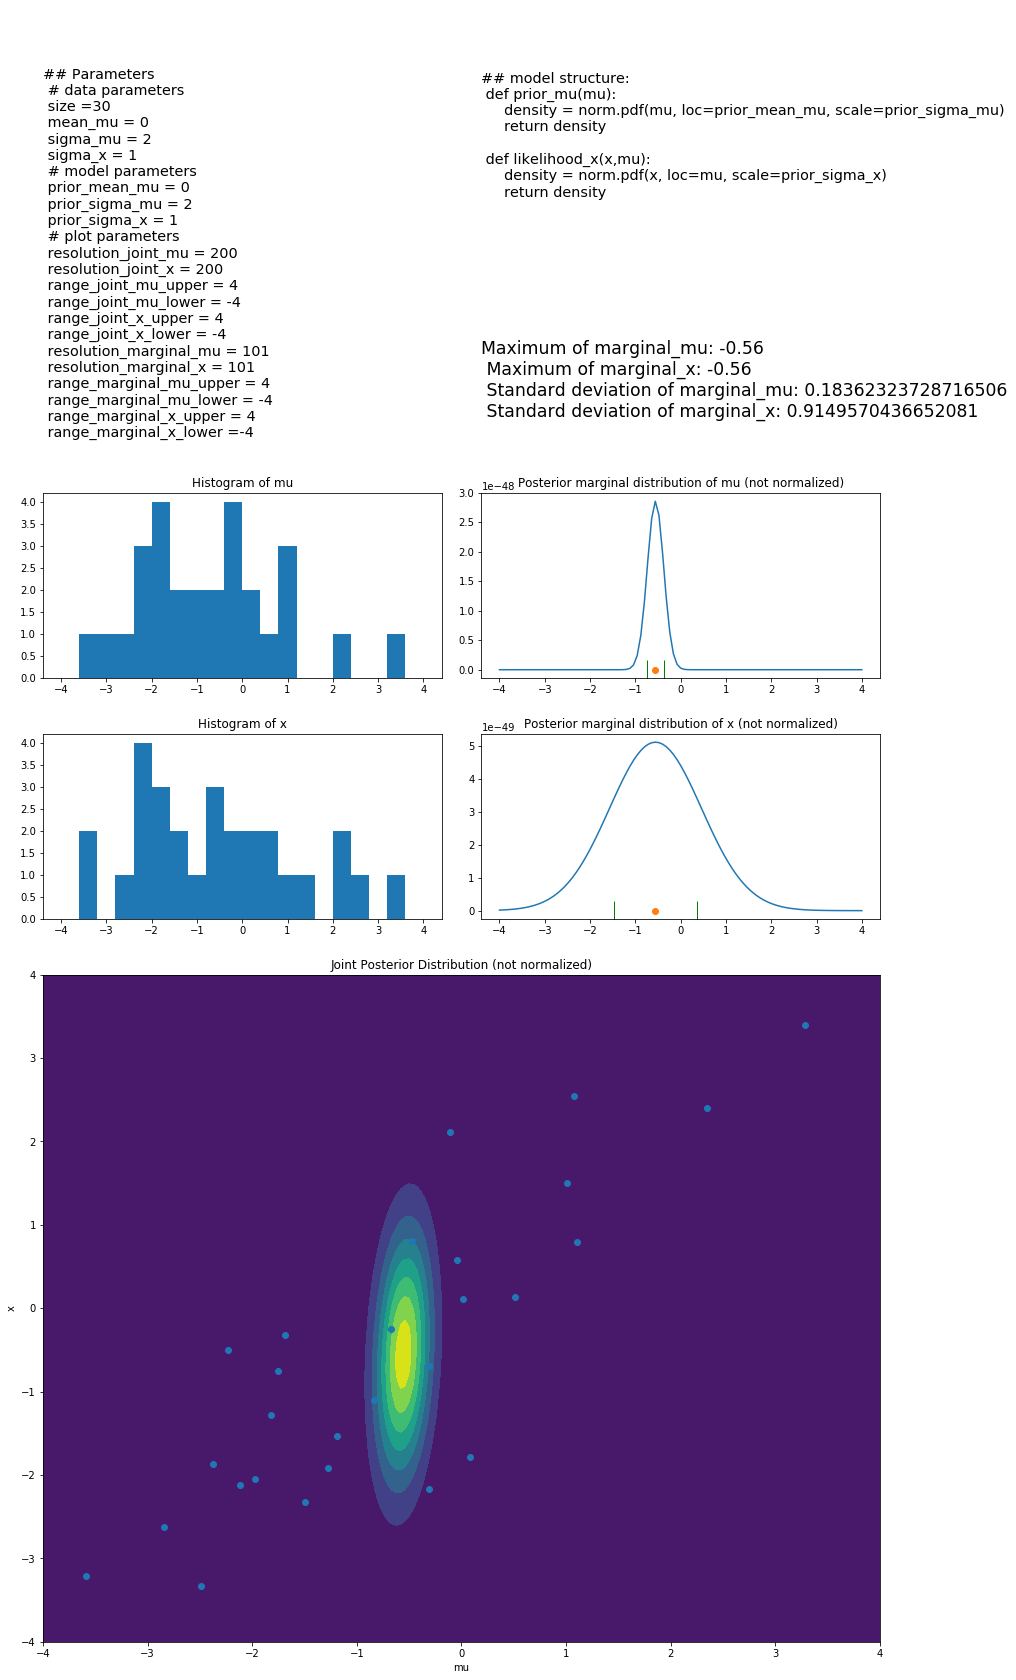

In [165]:
## Plot posterior distributions

plt.figure(figsize=(15,30))
vis_grid = plt.GridSpec(7, 2, wspace=0.1, hspace=0.3)

plt.subplot(vis_grid[0:2, 0])
axis('off')
plt.text(0,0,
'## Parameters \n \
# data parameters \n \
size =' + str(size)+ '\n \
mean_mu = ' + str(mean_mu)+ '\n \
sigma_mu = ' + str(sigma_mu)+ ' \n \
sigma_x = ' + str(sigma_x)+ ' \n \
# model parameters \n \
prior_mean_mu = ' + str(prior_mean_mu)+ ' \n \
prior_sigma_mu = ' + str(prior_sigma_mu)+ ' \n \
prior_sigma_x = ' + str(prior_sigma_x)+' \n \
# plot parameters \n \
resolution_joint_mu = ' + str(resolution_joint_mu)+' \n \
resolution_joint_x = ' + str(resolution_joint_x)+' \n \
range_joint_mu_upper = ' + str(range_joint_mu_upper)+' \n \
range_joint_mu_lower = ' + str(range_joint_mu_lower)+' \n \
range_joint_x_upper = ' + str(range_joint_x_upper)+' \n \
range_joint_x_lower = ' + str(range_joint_x_lower)+' \n \
resolution_marginal_mu = ' + str(resolution_marginal_mu)+' \n \
resolution_marginal_x = ' + str(resolution_marginal_x)+' \n \
range_marginal_mu_upper = ' + str(range_marginal_mu_upper)+' \n \
range_marginal_mu_lower = ' + str(range_marginal_mu_lower)+' \n \
range_marginal_x_upper = ' + str(range_marginal_x_upper)+' \n \
range_marginal_x_lower =' + str(range_marginal_x_lower),
        fontsize ='x-large')

plt.subplot(vis_grid[0, 1])
axis('off')
plt.text(0,0,
'## model structure: \n \
def prior_mu(mu): \n \
    density = norm.pdf(mu, loc=prior_mean_mu, scale=prior_sigma_mu) \n \
    return density \n \
 \n \
def likelihood_x(x,mu): \n \
    density = norm.pdf(x, loc=mu, scale=prior_sigma_x) \n \
    return density',
        fontsize ='x-large') 

plt.subplot(vis_grid[1, 1])
axis('off')
plt.text(0,0,
'Maximum of marginal_mu: ' + str(mu_max_plot_position) + '\n \
Maximum of marginal_x: ' + str(x_max_plot_position) + '\n \
Standard deviation of marginal_mu: ' + str(simulated_mu_sd) + '\n \
Standard deviation of marginal_x: ' + str(simulated_x_sd) + '\n ',
        fontsize ='xx-large')

plt.subplot(vis_grid[2, 0])
hist(mu,range=[range_marginal_mu_lower,range_marginal_mu_upper],bins=20)
plt.title('Histogram of mu')

plt.subplot(vis_grid[2, 1:])
plt.plot(range_marginals_mu, marginals_mu)
plt.title('Posterior marginal distribution of mu (not normalized)')
plot([mu_max_plot_position], [0], 'o')
plot([mu_max_plot_position + simulated_mu_sd], [0], 'g|', markersize=20)
plot([mu_max_plot_position - simulated_mu_sd], [0], 'g|', markersize=20)
#plot([mu_max_plot_position + 2*simulated_mu_sd], [0], 'r|', markersize=20)
#plot([mu_max_plot_position - 2*simulated_mu_sd], [0], 'r|', markersize=20)

plt.subplot(vis_grid[3, 0])
hist(X,range=[range_marginal_x_lower,range_marginal_x_upper],bins=20)
plt.title('Histogram of x')

plt.subplot(vis_grid[3, 1:])
plt.plot(range_marginals_x, marginals_x)
plt.title('Posterior marginal distribution of x (not normalized)')
plot([x_max_plot_position], [0], 'o')
plot([x_max_plot_position + simulated_x_sd], [0], 'g|', markersize=20)
plot([x_max_plot_position - simulated_x_sd], [0], 'g|', markersize=20)
#plot([x_max_plot_position + 2*simulated_x_sd], [0], 'r|', markersize=20)
#plot([x_max_plot_position - 2*simulated_x_sd], [0], 'r|', markersize=20)

plt.subplot(vis_grid[4:7, :])
cnt = contourf(mu_plot, x_plot, grid)
plt.xlabel('mu')
plt.ylabel('x')
plt.ylim((range_joint_x_lower,range_joint_x_upper))
plt.xlim((range_joint_mu_lower,range_joint_mu_upper))
_ = plt.scatter(mu, X)
plt.title('Joint Posterior Distribution (not normalized)')